# Приоритизация гипотез и применение А/В теста.
**Цель исследования** — анализ гипотез для увеличения выручки интернет-магазина и проведение А/В теста. \
**Ход исследования**: Работа пройдёт в несколько этапов:
* Предобработка данных
* Приоритизация гипотез
* Анализ A/B-теста

### Загрузка и предобработка данных

Для начала импортируем необходимые библиотеки:

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

Загрузим данные из CSV-файлов в переменные:

In [2]:
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),
    pd.read_csv('/datasets/orders.csv'),
    pd.read_csv('/datasets/visitors.csv')
)

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Для удобства приведём названия столбцов в таблицах к общему стилю:

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()

Проверим типы данных в таблицах:

In [7]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Видим, что столбцы с датой в таблицах **orders** и **visitors** имеют формат ``object``, приведём их к типу ``datetime``:

In [10]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим таблицы на пропуски:

In [11]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [12]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

Затем на дубликаты:

In [13]:
orders.duplicated().sum()

0

In [14]:
visitors.duplicated().sum()

0

#### Вывод.
* Названия столбцов таблиц приведены к единому стилю
* Значения таблиц с датой преобразованы в формат `datetime`
* Пропуски и дубликаты в датасетах отсутствуют

Таким образом, выполнена предобработка данных и таблицы готовы к дальнейшему анализу.

### Приоритизация гипотез.

Применим фреймворк ``ICE`` для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [15]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 1)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Применим фреймворк ``RICE`` для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [16]:
hypothesis['RICE'] = round(hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 1)
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


#### Вывод.
Видим, что приоритизация гипотез при применении метода ``RICE`` изменилась: в формулу её расчёта был добавлен параметр **Reach**, который указывает на количество пользователей, которых затронут изменения. Соответственно, чем выше параметр **Reach**, тем сильнее поменялся приоритет каждой из гипотез. 
* Так, у гипотезы о скидке на товар в день рождения значительно упал приоритет, так как значение **Reach** было оценено на 1 балл.
* У гипотезы о добавлении формы подписки на основные страницы, напротив, приоритет был повышен с третьего до первого, так как значение **Reach** получило максимальную оценку — 10, что означает, что данное изменение охватит абсолютное большинство пользователей.
* Также большую оценку (8) охвата аудитории получила гипотеза о добавление блока рекомендаций, которая поднялась на вторую строчку по приоритету.

На мой взгляд, в данном случае метод ``RICE`` даёт более точную оценку приоритета той или иной гипотезы, так как важную роль в анализе деятельности интернет-магазина имеет параметр охвата аудитории. А значит, первым делом необходимо проверить гипотезу о добавлении формы подписки на все основные страницы для email-рассылок.

### Анализ A/B-теста.

Перед проведением теста изучим, сколько пользователей попало в каждую из групп, и случается ли, что заказы одного пользователя попадают в обе группы:

In [35]:
unique_users = orders.groupby('group')['visitorId'].nunique()
unique_users

group
A    503
B    586
Name: visitorId, dtype: int64

В группу А попало 503 пользователя, в группу В — 586.

In [41]:
users = orders.groupby('visitorId')
# считаем число пользователей, у которых заказы попали в разные группы теста
num_users = 0
for user_id, group_df in users:
    unique_groups = group_df['group'].unique()
    if len(unique_groups) > 1:
        num_users += 1
        
# считаем долю таких пользователей от общего числа пользователей
total_users = len(orders['visitorId'].unique())
ratio = num_users / total_users

print(f"Число пользователей, которые попали в обе группы теста: {num_users}")
print(f"Их отношение к общему числу пользователей: {ratio:.2%}")

Число пользователей, которые попали в обе группы теста: 58
Их отношение к общему числу пользователей: 5.63%


Таким образом, число пользователей, попавших в обе группы, составляет менее 6%, что, по-моему мнению, не критично отразится на результатах исследования. Мной было принято решение не удалять эти заказы из общих данных.

#### Построим график кумулятивной выручки по группам.

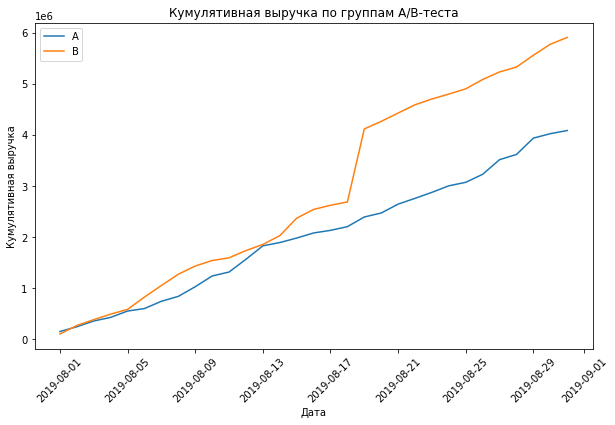

In [44]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
ax.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

# Добавляем заголовок
ax.set_title('Кумулятивная выручка по группам A/B-теста')

# Подписываем оси
ax.set_xlabel('Дата')
ax.set_ylabel('Кумулятивная выручка')

# Наклоняем надписи на оси X
plt.xticks(rotation=45)

ax.legend()
plt.show()

Результаты сегмента В стабильно опережали результаты сегмента А на протяжении всего теста. Кроме того, во второй половине месяца произошёл большой всплеск активности, что может указывать на аномально большие заказы либо на аномально резкий рост числа заказов.

#### Построим график кумулятивного среднего чека по группам. 

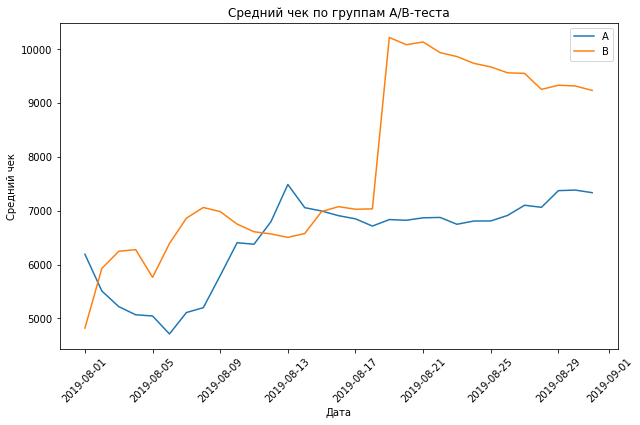

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
ax.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

ax.set_title('Средний чек по группам A/B-теста')

ax.set_xlabel('Дата')
ax.set_ylabel('Средний чек')

plt.xticks(rotation=45)

ax.legend()
plt.show()

График группы А ближе к середине месяца установился около отметки 7000 и оставался стабильным дальше. В группе В видим аномальное увеличение среднего чека во второй половине графика: возможно, на этот день пришлись крупные заказы. За всплеском следует постепенное снижение графика сраднего чека. Очевидно, что требуется дополнительный анализ выбросов.

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

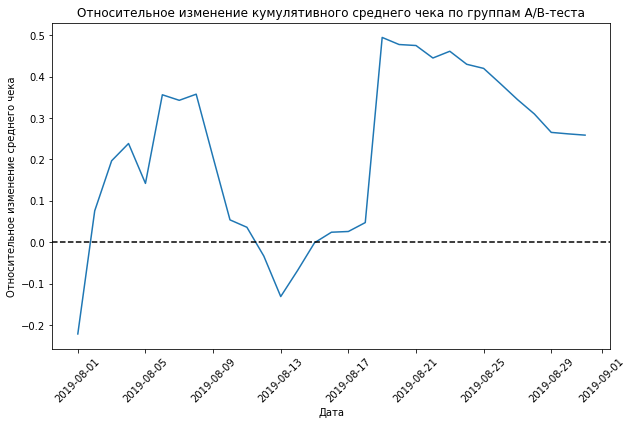

In [47]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig, ax = plt.subplots(figsize=(10, 6))

# cтроим отношение средних чеков
ax.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

ax.set_title('Относительное изменение кумулятивного среднего чека по группам A/B-теста')

ax.set_xlabel('Дата')
ax.set_ylabel('Относительное изменение среднего чека')

# Добавляем горизонтальную линию на уровне 0
ax.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=45)

plt.show()

Исходя из нестабильности данного графика, можно выразить уверенность в наличии крупных заказов и выбросов.

#### Построим график кумулятивного среднего количества заказов на посетителя по группам.

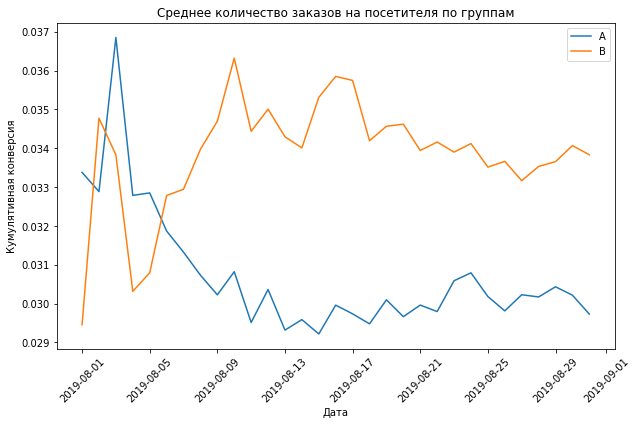

In [49]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

fig, ax = plt.subplots(figsize=(10, 6))

# строим графики
ax.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
ax.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

ax.set_title('Среднее количество заказов на посетителя по группам')

ax.set_xlabel('Дата')
ax.set_ylabel('Кумулятивная конверсия')

plt.xticks(rotation=45)

ax.legend()
plt.show()

Из данного графика видим, что сегмент В стабильно опережал сегмент А по данному параметру, разница между группами составляла от 0.4% до 0.6%.

#### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

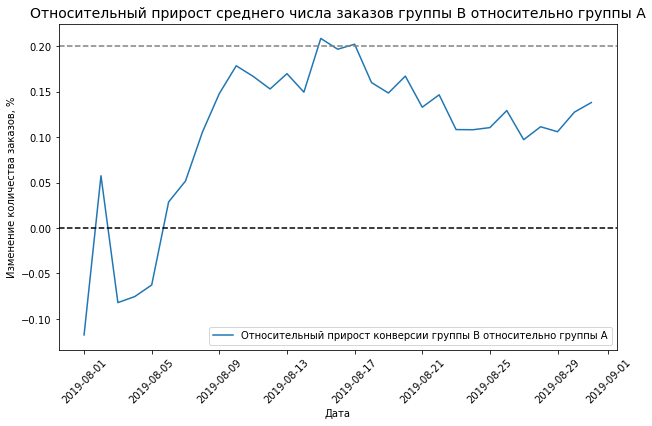

In [53]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10, 6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.title('Относительный прирост среднего числа заказов группы B относительно группы A', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Изменение количества заказов, %')
plt.xticks(rotation=45)

plt.show()

Видим, что группа В практически с самого начала теста вырвалась вперёд и к середине месяца достигла пика прироста в 20% относительно группы А, но во второй половине месяца этот показатель уменьшился, колебавшись на отметке 10-15%. \
Предварительно можно отметить успехи группы В, однако стоит проанализировать аномалии, возможно, они изменят общую картину.

#### Построим точечный график количества заказов по пользователям.

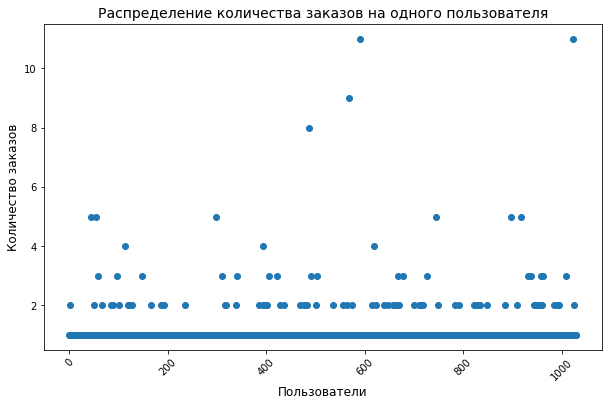

In [54]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)# Метод .groupby('...', as_index=False) сгруппирует заказы по пользователям
    .agg({'transactionId': 'nunique'})# Метод .agg({'...' : 'nunique',}) подсчитает число уникальных заказов по   сгруппированным данным
)
ordersByUsers.columns = ['userId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(10, 6))
plt.scatter(x_values, ordersByUsers['orders'])

# Заголовок
plt.title('Распределение количества заказов на одного пользователя', fontsize=14)

# Подпись оси X
plt.xlabel('Пользователи', fontsize=12)

# Подпись оси Y
plt.ylabel('Количество заказов', fontsize=12)

# Наклон подписей по оси X
plt.xticks(rotation=45)

plt.show()

Видим, что относительно небольшое количество пользователей делали заказ более двух раз. 

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [23]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Предположение в предыдущем шаге оказалось верным — не более 5% пользователей совершали больше двух заказов и не более 1% — больше четырёх. В данном случае разумно выбрать 2 заказа за верхнюю границу числа заказов.

#### Построим точечный график стоимостей заказов.

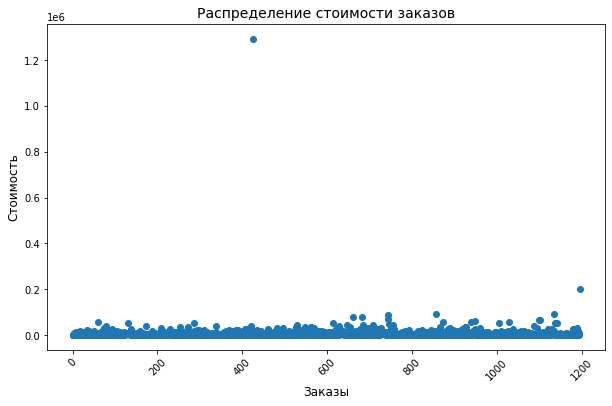

In [57]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(10, 6))
plt.scatter(x_values, orders['revenue'])

plt.title('Распределение стоимости заказов', fontsize=14)
plt.xlabel('Заказы', fontsize=12)
plt.ylabel('Стоимость', fontsize=12)
plt.xticks(rotation=45)

plt.show()

По этому графику определить точную границу аномальных заказов трудно, но видно что дорогих заказов очень мало. Лучше обратиться к поиску выборочных перцентилей.

Видим, что из-за двух выбросов график стал неинформативным. Уберём их, установив нижнюю границу выбросов — 150000 у.е., и построим график заново:

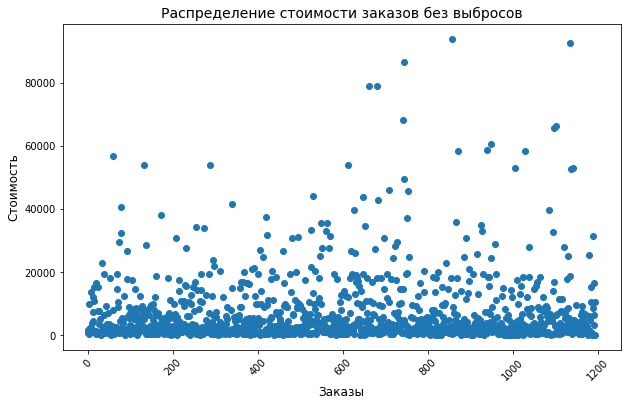

In [60]:
# Убираем выбросы
filtered_orders = orders[orders['revenue'] <= 150000]

x_values = pd.Series(range(0, len(filtered_orders['revenue'])))
plt.figure(figsize=(10, 6))
plt.scatter(x_values, filtered_orders['revenue'])

plt.title('Распределение стоимости заказов без выбросов', fontsize=14)
plt.xlabel('Заказы', fontsize=12)
plt.ylabel('Стоимость', fontsize=12)
plt.xticks(rotation=45)

plt.show()

#### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [25]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более, чем у 5% заказов стоимость заказов выше 28000 у.е., и не больше, чем у 1% заказов — выше 58233 у.е. Таким образом, разумно взять 28000 как нижнюю границу аномалий.

Итак, можем с достаточной уверенностью сказать, что 95% пользователей совершают не более двух заказов на сумму не более 28000 у.е. Эти цифры в дальнейшем будут использоваться для среза аномалий.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов по «сырым» данным между группами нет. Альтернативная: различия в среднем количестве заказов по «сырым» данным между группами есть. Установим уровень статистической значимости 5%.

Для начала подготовим данные, пересобрав их в новую таблицу с нужными нам метриками:

In [26]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

Теперь посчитаем статистическую значимость различия в среднем количестве заказов между группами. Для этого создадим вспомогательные переменные и применим критерий Манна-Уитни:

In [63]:
alpha = 0.05 # задаём значение уровня значимости

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

if stats.mannwhitneyu(sampleA, sampleB)[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Относительное различие между группами:', "{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

p-value: 0.01679
Отвергаем нулевую гипотезу
относительное различие между группами: 0.138


P-value меньше 0,05, поэтому нулевую гипотезу отвергаем. Анализ "сырых данных" говорит о том, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост количества заказов равен 13,8%.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы. Нулевая: различий в среднем чеке по «сырым» данным между группами нет. Альтернативная: различия в среднем чеке по «сырым» данным есть. Установим уровень статистической значимости 5%.

In [64]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

if stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Относительное различие между группами:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.729
Не получилось отвергнуть нулевую гипотезу
Относительное различие между группами: 0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. \
Но при этом видим, что средний чек группы В на 25% выше среднего чека группы А. Это может говорить о каких-то разовых аномалиях в группе В.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 

In [65]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] >= 3]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('Количество аномальных пользователей:', abnormalUsers.shape[0])

Количество аномальных пользователей: 74


Получилось 74 аномальных пользователя. Теперь можем вычислить статистическую значимость по «очищенным» данным:

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов по «очищенным» данным между группами нет. Альтернативная: различия в среднем количестве заказов по «очищенным» данным между группами есть. Установим уровень статистической значимости 5%.

In [66]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', '{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

if stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Относительное различие между группами:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.01304
Отвергаем нулевую гипотезу
Относительное различие между группами: 0.173


Так же, как и в случае с "сырыми данными", статистическая значимость достигнута. А относительный прирост среднего количества заказов в сравнении с "сырыми данными" даже увеличился, составив 17,3%.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем гипотезы. Нулевая: различий в среднем чеке по «очищенным» данным между группами нет. Альтернативная: различия в среднем чеке по «очищенным» данным есть. Установим уровень статистической значимости 5%.

In [68]:
results_pvalue = stats.mannwhitneyu(
                    orders[
                        np.logical_and(
                            orders['group'] == 'A',
                            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                        )
                    ]['revenue'],
                    orders[
                        np.logical_and(
                            orders['group'] == 'B',
                            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                        )
                    ]['revenue'],
                )[1]

print('p-value:', '{0:.3f}'.format(results_pvalue))

if results_pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print(
    'Относительное различие между группами:',    
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.738
Не получилось отвергнуть нулевую гипотезу
Относительное различие между группами: -0.020


Статистическая значимость, как и в случае с "сырыми данными", не была достигнута, а значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Но после удаления выбросов снизилось различие в средних чеках, которое теперь составляет всего 2% не в пользу сегмента В.

### Вывод по результатам A/B-теста:

#### Сформулируем промежуточные выводы:

* Кумулятивная выручка сегмента В стабильно опережала сегмент А на протяжении всего теста. 
* Сегмент В стабильно был впереди сегмента А по параметру среднего количества заказов.
* Уровень прироста среднего количества заказов группы В относительно группы А к концу теста зафиксировался в районе 15%.
* С учётом отсева аномальных значений относительный прирост среднего количества заказов группы В к конверсии группы А составил 17,3% и была достигнута статистическая значимость различия между группами.
* Однако, статистическая значимость различия между группами по средней величине среднего чека не была достигнута, а значит, причин считать, что в этом аспекте между группами есть различия, нет.


#### Общий вывод.
Если мы рассматриваем выручку как произведение среднего чека на количество заказов, то логично сделать вывод, что при общем увеличении числа заказов и неизменном среднем чеке выручка вырастет пропорционально увеличению числа заказов. Это означает, что тест следует остановить и признать успешным, зафиксировать победу группы B.